In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from PIL import Image,ImageFile
from random import shuffle
from scipy.ndimage import rotate
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from collections import Counter

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
print(os.listdir('/kaggle/input'))
# Any results you write to the current directory are saved as output.

['diabret05']


In [3]:
!ls

__notebook_source__.ipynb


In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
# data source : https://github.com/javathunderman/retinopathy-dataset
# problem statement : 2 classes => symptoms and no-symptoms

In [6]:
tf.__version__

'2.1.0-rc0'

In [7]:
## data read

In [8]:
sympdata_path = '/kaggle/input/diabret05/diabetic_retinopathy/project_data/symptoms/'
nonsympdata_path = '/kaggle/input/diabret05/diabetic_retinopathy/project_data/nosymptoms/'

In [9]:
symptoms_files = [sympdata_path+i for i in os.listdir(sympdata_path)]
nosymptoms_files = [nonsympdata_path+i for i in os.listdir(nonsympdata_path)]

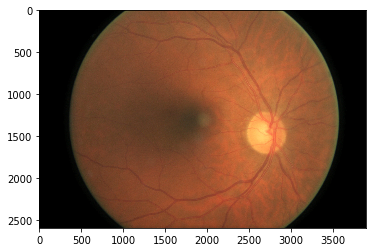

In [10]:
test_file = nosymptoms_files[0]
ab1 = Image.open(test_file)
plt.imshow(ab1)

(2592, 3888)


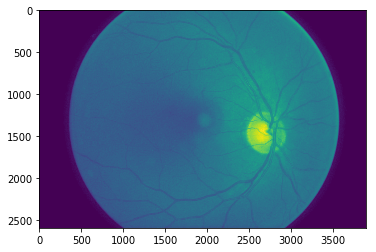

In [11]:
ab1 = np.array(ab1)
print(ab1[:,:,1].shape)
plt.imshow(ab1[:,:,1])

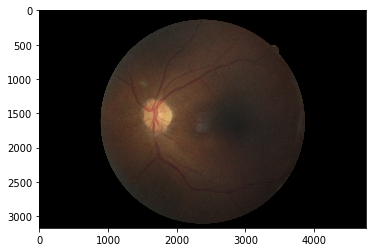

In [12]:
test_file = symptoms_files[0]
ab = Image.open(test_file)
plt.imshow(ab)

In [13]:
len(symptoms_files)

1513

In [14]:
len(nosymptoms_files)

1600

In [15]:
shuffle(symptoms_files)
shuffle(nosymptoms_files)
train_symptom = symptoms_files[:500]
train_nonsymptom = nosymptoms_files[:500]
# test_symptom = symptoms_files[550:650]
# test_nonsymptom = nosymptoms_files[550:650]

In [16]:
train_X = train_symptom + train_nonsymptom
train_y = [1]*len(train_symptom) + [0]*len(train_nonsymptom)
train = list(zip(train_X,train_y))
shuffle(train)
train_X,train_y = zip(*train)
# vald = test_symptom + test_nonsymptom
# val_y = [1]*len(test_symptom) + [0]*len(test_nonsymptom)

In [17]:
size = 512

In [18]:
testcsv = pd.read_csv('/kaggle/input/diabret05/diabetic_retinopathy/project_data/test_labels.csv',header=0)
val_data = {'/kaggle/input/diabret05/diabetic_retinopathy/project_data/test/'+row.image+'.jpeg':row.level for i,row in testcsv.iterrows()}
vald = {}
counter = 0
for i in val_data:
    if val_data[i]==0 and counter<50:
        vald[i]=val_data[i]
        counter+=1
    elif val_data[i]==1:
        vald[i]=val_data[i]

In [ ]:
# tm = []
# p = 0
# for i in train_X:
#   tm.append(np.expand_dims(np.array(Image.open(i).resize((size,size)))[:,:,1],3))
#   p+=1
#   print(p)
# trainX = np.array(tm)
# del tm
# trainX = np.array([np.expand_dims(Image.open(i).resize((size,size)).convert('L'),3) for i in train_X])
trainX = np.array([np.expand_dims(np.array(Image.open(i).resize((size,size)))[:,:,1],3) for i in train_X])
#trainX = np.array([np.array(Image.open(i).resize((size,size))) for i in train_X])
trainX = trainX/255.0
print(len(train_y),trainX.shape)
c = Counter(train_y)
print(c)

In [ ]:
# valX = np.array([np.expand_dims(Image.open(i).resize((size,size)).convert('L'),3) for i in vald])
valX = np.array([np.expand_dims(np.array(Image.open(i).resize((size,size)))[:,:,1],3) for i in vald])
# valX = np.array([np.array(Image.open(i).resize((size,size))) for i in vald])
valX = valX/255.0
val_y = [vald[i] for i in vald]
print(valX.shape)
print(len(val_y))
c = Counter(val_y)
print(c)

In [ ]:
print(trainX.shape)
print(valX.shape)

train_y = np.array(train_y)
val_y = np.array(val_y)

train_y = train_y.reshape(-1,1)
val_y = val_y.reshape(-1,1)

print(train_y.shape)
print(val_y.shape)

In [ ]:
def plot_metric(modelname,train,val,metric='accuracy'):
    plt.plot(train)
    plt.plot(val)
    plt.legend(['train','validation'])
    plt.ylabel(metric)
    plt.xlabel('train_iterations')
    plt.savefig(modelname+'_'+metric+'.png', bbox_inches='tight')
    plt.show()

def plot_acc_loss(modelname,history_train_acc,history_train_loss,history_val_acc,history_val_loss):
    plot_metric(modelname,history_train_acc,history_val_acc)
    plot_metric(modelname,history_train_loss,history_val_loss,'loss')

In [ ]:
def basemodel(modelfilename,trainX,train_y,valX,val_y,epoch=20,batchsize=10):
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=modelfilename,save_best_only=True,monitor='val_loss',verbose=2)]
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64,kernel_size=7,strides=1,activation='relu', input_shape=(size,size,1)),
        tf.keras.layers.MaxPooling2D(pool_size=3,strides=2),
        tf.keras.layers.Conv2D(64,kernel_size=5,strides=1,activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=3,strides=2),
        tf.keras.layers.Conv2D(128,kernel_size=5,strides=1,activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=3,strides=2),
        tf.keras.layers.Conv2D(128,kernel_size=5,strides=1,activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=4,strides=4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(x=trainX,
                        y=train_y,
                        validation_data=[valX,val_y],
                        batch_size=batchsize,
                        callbacks=callbacks,
                        epochs=epoch,
                        use_multiprocessing=True,
                        verbose=2)
    return model,history

In [ ]:
model,history = basemodel('DRmodel_NEW.h5',trainX,train_y,valX,val_y,epoch=200,batchsize=8)
history_train_acc = history.history['accuracy']
history_train_loss = history.history['loss']
history_val_acc = history.history['val_accuracy']
history_val_loss = history.history['val_loss']

In [ ]:
plot_acc_loss('basic_n',history_train_acc[:45],history_train_loss[:45],history_val_acc[:45],history_val_loss[:45])

# Transfer Learning from InceptionV3 model

In [20]:
from tensorflow.keras.applications import InceptionV3

In [21]:
bml = InceptionV3(weights='imagenet',include_top=False,input_shape=(512,512,3))

87916544/87910968 [==============================] - 2s 0us/step


In [22]:
bml.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [23]:
shuffle(symptoms_files)
shuffle(nosymptoms_files)
train_symptom = symptoms_files[:500]
train_nonsymptom = nosymptoms_files[:500]

train_X = train_symptom + train_nonsymptom
train_y = [1]*len(train_symptom) + [0]*len(train_nonsymptom)
train = list(zip(train_X,train_y))
shuffle(train)
train_X,train_y = zip(*train)

size = 256

testcsv = pd.read_csv('/kaggle/input/diabret05/diabetic_retinopathy/project_data/test_labels.csv',header=0)
val_data = {'/kaggle/input/diabret05/diabetic_retinopathy/project_data/test/'+row.image+'.jpeg':row.level for i,row in testcsv.iterrows()}
vald = {}
counter = 0
for i in val_data:
    if val_data[i]==0 and counter<50:
        vald[i]=val_data[i]
        counter+=1
    elif val_data[i]==1:
        vald[i]=val_data[i]
        
trainX = np.array([np.array(Image.open(i).resize((size,size))) for i in train_X])
#trainX = np.array([np.array(Image.open(i).resize((size,size))) for i in train_X])
trainX = trainX/255.0
print(len(train_y),trainX.shape)
c = Counter(train_y)
print(c)

print('training data done')

# valX = np.array([np.expand_dims(Image.open(i).resize((size,size)).convert('L'),3) for i in vald])
valX = np.array([np.array(Image.open(i).resize((size,size))) for i in vald])
# valX = np.array([np.array(Image.open(i).resize((size,size))) for i in vald])
valX = valX/255.0
val_y = [vald[i] for i in vald]
print(valX.shape)
print(len(val_y))
c = Counter(val_y)
print(c)

print('validation data done')

print(trainX.shape)
print(valX.shape)

train_y = np.array(train_y)
val_y = np.array(val_y)

train_y = train_y.reshape(-1,1)
val_y = val_y.reshape(-1,1)

print(train_y.shape)
print(val_y.shape)

1000 (1000, 256, 256, 3)
Counter({1: 500, 0: 500})
training data done
(105, 256, 256, 3)
105
Counter({1: 55, 0: 50})
validation data done
(1000, 256, 256, 3)
(105, 256, 256, 3)
(1000, 1)
(105, 1)


In [24]:
print(trainX.shape)
print(valX.shape)
print(train_y.shape)
print(val_y.shape)

(1000, 256, 256, 3)
(105, 256, 256, 3)
(1000, 1)
(105, 1)


In [ ]:
def inceptionmodel_tfl(bml,modelfilename,trainX,train_y,valX,val_y,epoch=50,batchsize=5):
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=modelfilename,
                                                    save_best_only=True,
                                                    monitor='val_loss',
                                                    verbose=2)]
    tf.keras.backend.clear_session()
    bml.trainable = False  #setting the trainable property of InceptionV3 part false
    model = tf.keras.Sequential([
        bml,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(x=trainX,
                        y=train_y,
                        validation_data=[valX,val_y],
                        batch_size=batchsize,
                        callbacks=callbacks,
                        epochs=epoch,
                        use_multiprocessing=True,
                        verbose=2)
    return model,history

In [ ]:
model_n,history_n = inceptionmodel_tfl(bml,'InceptionDRmodel.h5',trainX,train_y,valX,val_y,epoch=50,batchsize=5)

In [ ]:
history_train_acc = history_n.history['accuracy']
history_train_loss = history_n.history['loss']
history_val_acc = history_n.history['val_accuracy']
history_val_loss = history_n.history['val_loss']
plot_acc_loss('augmented_basic',history_train_acc,history_train_loss,history_val_acc,history_val_loss)

In [ ]:
# test_ypred = model.predict_classes(testX)
# print('Accuracy : ',accuracy_score(test_ypred,test_y))
# print('F1-Score : ',f1_score(test_ypred,test_y))
# print('Precsion Score : ',precision_score(test_ypred,test_y))
# print('Recall Score : ',recall_score(test_ypred,test_y))